In [2]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import HBox, VBox, jslink, Box, Layout
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, Image
from scipy.integrate import solve_ivp

In [3]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 5px 5px 0px',
        padding='2px 2px 2px 2px'
     )

# Regelung eines Systems 1. Ordnung: Vergleich Sprung vs. Trajektorie

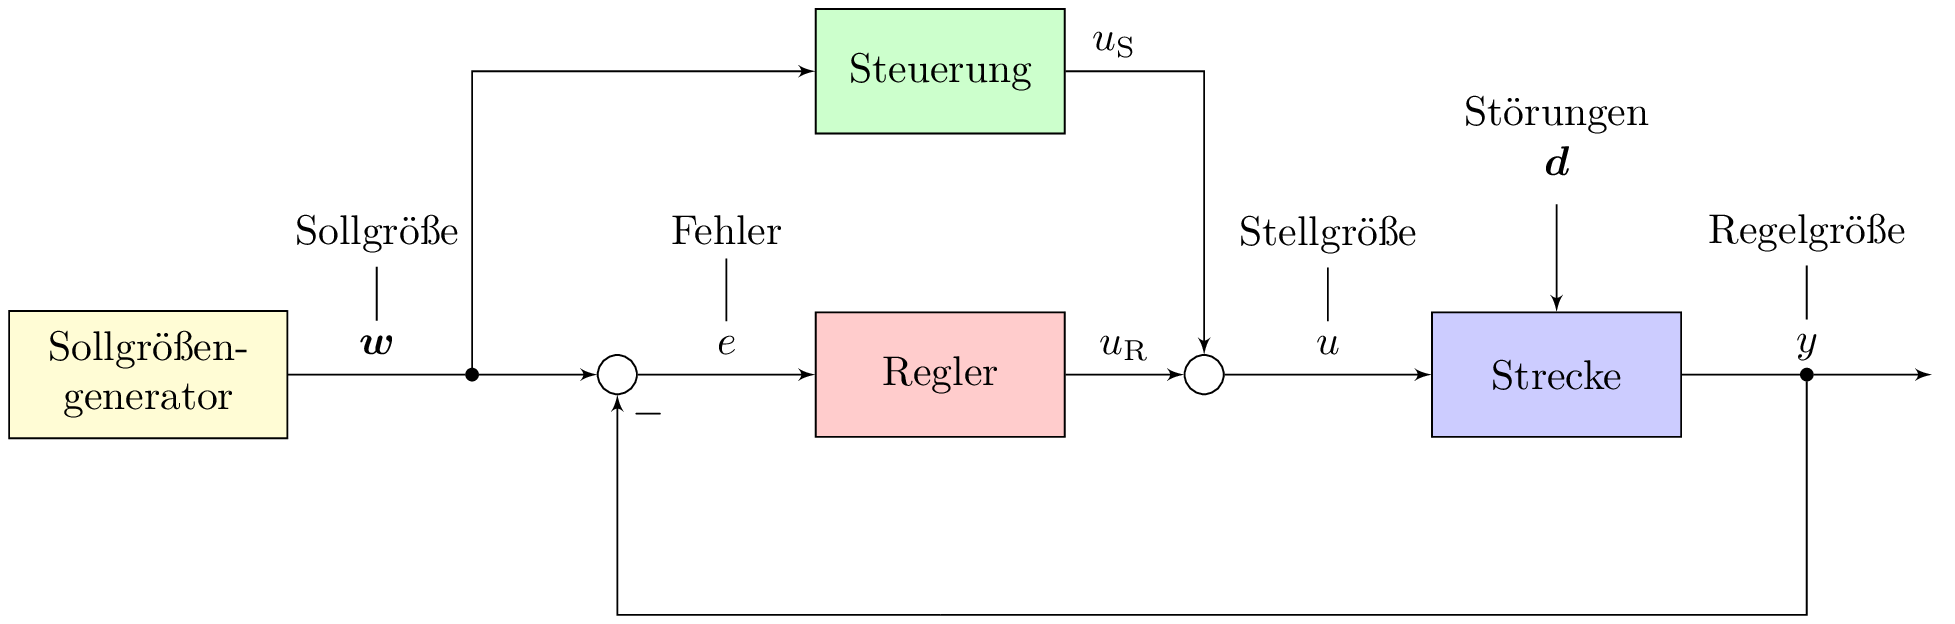

In [4]:
imag = Image("../../images/feedback.png", width=600)
display(imag)

## System erster Ordnung

\begin{align*}
    \dot{y}(t) + (a + \Delta a) y(t) & = b u(t)
\end{align*}
mit Ausgang $y$, der Steuerung
\begin{align*}
    u_{\mathrm{S}}(t) & = \frac{1}{b}\left(\dot{y}_{\mathrm{r}}(t) + a y_{\mathrm{r}}(t) \right)
\end{align*}
und Regelung
\begin{align*}
    u_{\mathrm{R}}(t) & = K_{\mathrm{P}} e(t) + \int_{t_0}^{t} e(\tau) \text{d} \tau
\end{align*}

__Defintion Parameter__

In [ ]:
tSim = np.linspace(0, 5, 1001)
x0 = [0, 0]
t0 = 1

**Simulation**

In [ ]:
output = widgets.Output()

with output:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})

plt.subplots_adjust(wspace=0.2, hspace=0.07)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.subplots_adjust(bottom=0.1, top=0.93, left=0.125, right=0.9)

ax1.set_xlim([0, tSim[-1]]) 
ax2.set_xlim([0, tSim[-1]]) 
ax3.set_xlim([0, tSim[-1]]) 
ax1.set_ylim([-0.05, 3.55]) 
ax2.set_ylim([-2, 2]) 
ax3.set_ylim([-2, 2]) 
ax1.grid()
ax2.grid()
ax3.grid()
ax1.set_ylabel(r"$y$")
ax2.set_ylabel(r"$e$")
ax3.set_ylabel(r"$u$")
ax3.set_xlabel(r"$t$")

ySys, = ax1.plot([], [], 'C0', label=r'Prozess')
yRefSys, = ax1.plot([], [], 'C1', label=r'Referenz')
eSys, = ax2.plot([], [], 'C0', label=r'Fehler $e$')
uFFSys, = ax3.plot([], [], 'C1', label=r'Steuerung $u_{\mathrm{S}}$')
uFBSys, = ax3.plot([], [], 'C2', label=r'Regler')

handlesAx1, labelsAx1 = ax1.get_legend_handles_labels()
handlesAx3, labelsAx3 = ax3.get_legend_handles_labels()

handlesAx = handlesAx1 + handlesAx3
labelsAx = labelsAx1 + labelsAx3
axOrder = [0, 1, 3]

fig.legend([handlesAx[idx] for idx in axOrder],
           [labelsAx[idx] for idx in axOrder],
           bbox_to_anchor=(0.13, 0.94, 0.7675, .15), loc=3,
           ncol=3, mode="expand", borderaxespad=0., framealpha=0.5)

radioU = widgets.RadioButtons(options=['Sprung', 'Trajektorie'],
                              description='Eingang:',
                              disabled=False)
radioCtrl = widgets.RadioButtons(options=['Steuerung + PI', 'PI'],
                                 description='Regler:',
                                 disabled=False)
sliderDt = widgets.FloatSlider(value=3,
                               min=1,
                               max=4,
                               step=1,
                               description=r'$\Delta t$')
sliderYd = widgets.FloatSlider(value=2,
                               min=0.5,
                               max=2.5,
                               step=0.5,
                               description=r'$y_{\mathrm{d}}$')
sliderA = widgets.FloatSlider(value=3,
                              min=1,
                              max=4,
                              step=1,
                              description='a')
sliderDa = widgets.FloatSlider(value=0,
                               min=0,
                               max=1,
                               step=0.2,
                               description=r'$\Delta a$')
sliderB = widgets.FloatSlider(value=4,
                              min=3,
                              max=5,
                              step=1,
                              description='b')
sliderKp = widgets.FloatSlider(value=0,
                               min=0,
                               max=20,
                               step=1,
                               description=r'$K_\mathrm{P}$')
sliderKi = widgets.FloatSlider(value=0,
                               min=0,
                               max=20,
                               step=0.1,
                               description=r'$K_\mathrm{I}$')


def calcSystem(_):
    dt = sliderDt.value
    yd = sliderYd.value

    a = sliderA.value
    da = sliderDa.value
    b = sliderB.value
    Kp = sliderKp.value
    Ki = sliderKi.value

    def prozess(t, x, uTraj, a, da, b, Kp, Ki, opt):
        e = yr(t) - x[0]
        
        if opt == 'Steuerung + PI':
            uCtrl = Kp * e + Ki * x[1]
            u = uTraj(t) + uCtrl 
        else: # PI
            uCtrl = Kp * e + Ki * x[1]
            u = uCtrl
        
        dx = np.zeros(2)
        dx[0] = -(a + da) * x[0] + b * u
        dx[1] = e
        return dx
        
    if radioU.value == 'Sprung':
        yr = lambda t: yd if t > t0 else 0
        uTraj = lambda t: yd * a / b if t > t0 else 0
    else:
        yr = lambda t: yd * (3 * (t - t0) ** 2 / dt ** 2 - 2 * (t - t0) ** 3 / dt ** 3) if t0 <= t <= t0 + dt else 0 if t < t0 else yd 
        dyr = lambda t: yd * (6 * (t - t0) / dt ** 2 - 6 * (t - t0) ** 2 / dt ** 3) if t0 < t < t0 + dt else 0
        uTraj = lambda t: 1 / b * (dyr(t) + a * yr(t))
    
    res = solve_ivp(prozess,
                    [tSim[0], tSim[-1]],
                    x0,
                    t_eval=tSim, args=(uTraj, a, da, b, Kp, Ki, radioCtrl.value))
    
    sigFB = [Kp * (yr(t) - res.y.T[idx, 0]) + Ki * res.y.T[idx, 1] for idx, t in enumerate(tSim)]
    sigE = [yr(t) - res.y.T[idx, 0] for idx, t in enumerate(tSim)]
    uFBSys.set_data(tSim, sigFB)
    uFFSys.set_data(tSim, [uTraj(t) for t in tSim])
    ySys.set_data(tSim, res.y.T[:, 0])
    yRefSys.set_data(tSim, [yr(t) for t in tSim])
    eSys.set_data(tSim, sigE)
    
    uMax = np.max([np.max(sigFB), np.max([uTraj(t) for t in tSim])])
    ax2.set_ylim([-(np.max(sigE) + 0.2), (np.max(sigE) + 0.2)]) 
    ax3.set_ylim([-(uMax + 1), (uMax + 1)]) 
    
    fig.canvas.draw()

sliderA.observe(calcSystem, names='value')
sliderDa.observe(calcSystem, names='value')
sliderB.observe(calcSystem, names='value')

sliderDt.observe(calcSystem, names='value')
sliderYd.observe(calcSystem, names='value')
sliderKp.observe(calcSystem, names='value')
sliderKi.observe(calcSystem, names='value')

radioU.observe(calcSystem, names='value')
radioCtrl.observe(calcSystem, names='value')

calcSystem(_)

ffControls = VBox([sliderYd, sliderDt, sliderKp, sliderKi])
ffControls.layout = make_box_layout()
sysControls = VBox([sliderA, sliderDa, sliderB])
sysControls.layout = make_box_layout()
inputControls = VBox([radioU, radioCtrl])
inputControls.layout = make_box_layout()

controls = HBox([sysControls, inputControls, ffControls])
VBox([controls, output], layout=Layout(display='flex', flex_flow='row', justify_content='center', align_items='center'))